En este código se va a coger un archivo xml sacado del flight_plan de PprzGCS de donde sacaremos los puntos de paso. Con el optimizador sacaremos la ruta óptima y finalmente modificaremos el xml para llevarlo a paparazzi

In [14]:
#Cargamos los módulos que se van a necesitar
import pandas as pd

import numpy as np

import matplotlib
matplotlib.use('Qt5Agg')  # Cambia el backend a Qt5Agg para mostrar ventanas gráficas
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist
from pymoo.core.problem import ElementwiseProblem

from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_score

from matplotlib import style

#Para que el primer punto sea el inicial
from pymoo.core.repair import Repair 

#Diferentes funciones de la biblioteca para optimizar (pymoo)
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.problems.single.traveling_salesman import create_random_tsp_problem
from pymoo.operators.sampling.rnd import PermutationRandomSampling
from pymoo.operators.crossover.ox import OrderCrossover
from pymoo.operators.mutation.inversion import InversionMutation
from pymoo.termination.default import DefaultSingleObjectiveTermination
from pymoo.operators.mutation.bitflip import BitflipMutation

In [15]:
from lxml import etree

# Ruta a tu archivo XML y DTD
xml_file = '/home/dacya-iagesbloom/Documents/paparazzi/conf/flight_plans/UCM/steering_rover_gvfMission_parametric_bare.xml'
dtd_file = '/home/dacya-iagesbloom/Documents/paparazzi/conf/flight_plans/flight_plan.dtd'

# Cargar el DTD
with open(dtd_file, 'r') as dtd_f:
    dtd = etree.DTD(dtd_f)

# Cargar el archivo XML
with open(xml_file, 'r') as xml_f:
    xml_content = xml_f.read()

# Validar el XML contra el DTD
try:
    xml_doc = etree.fromstring(xml_content)
    if dtd.validate(xml_doc):
        print("El archivo XML es válido.")
    else:
        print("El archivo XML no es válido.")
        print("Errores:")
        for error in dtd.error_log:
            print(f"Línea {error.line}: {error.message}")
except etree.XMLSyntaxError as e:
    print("Error de sintaxis XML:")
    print(e)


El archivo XML es válido.


In [25]:
#En primer lugar cargamos todos los archivos necesarios. Estos son los siguientes:
#1- Datos.txt -> Nos dice si queremos mapa o no, número de segmentos y número de puntos de control
#2- Coordenadas.txt -> Nos dice las coordenadas de los puntos de control
#3- flight_plan -> Nos da todos los datos de lo que se desea en la ruta (Puntos de paso, regiones...)

#flightplan_entrada = input("Introduce el archivo que quiere optimizar con la extensión .xml: ")
#flightplan_salida = input("Introduce como quiere llamar archivo de salida con .xml: ")

#Leemos los archivos sacados del boton de planificación
Estrategia = pd.read_csv('/home/dacya-iagesbloom/Desktop/PprzGCS/datos.txt', delimiter=':', header = None) #Datos.txt
Coordenadas = pd.read_csv('/home/dacya-iagesbloom/Desktop/PprzGCS/coordenadas.txt', delimiter=',', header=None) #Coordenadas.txt

#Carga de archivo XML
import xml.etree.ElementTree as ET
from xml.dom import minidom

tree = ET.parse('/home/dacya-iagesbloom/Documents/paparazzi/conf/flight_plans/UCM/PRUEBA2_steering_rover_gvfMission_parametric_bare.xml')
root = tree.getroot()

# Encontrar todos los waypoints
way_points = root.find('waypoints')
waypoint_list = []
unchanged_points = []

#RECORDATORIO CHECKPOINT: EL CÓDIGO ESTABA HECHO PARA DECLARAR LAS VARIABLES CON X,Y NO CON LON LAT. EL PROBLEMA VIENE DE QUE CON
#EL FLIGHT_PLAN HECHO POR MI EL SIMULADOR NO SIGUE BIEN LA RUTA. POR TANTO, ESTOY PROBANDO CON UNO QUE (A VECES) SÍ QUE HACE BIEN 
#LA RUTA. PERO HAY QUE O PASAR LON Y LAT A X E Y O QUE SEA CAPAZ DE LEER LON, LAT

# Almacenar los waypoints existentes en una lista
for waypoint in way_points.findall('waypoint'):
    name = waypoint.get('name')
    #print(name)
    if name.startswith('BZ'):
        lat = float(waypoint.get('lat'))
        lon = float(waypoint.get('lon'))
        print(waypoint.get('lon'))
        print(lon)
        #print(type(lat))
        #waypoint_list.append((name, x, y))
        waypoint_list.append((name, lat, lon))
    else:
        x = float(waypoint.get('x'))
        y = float(waypoint.get('y'))
        unchanged_points.append((name, x, y))
        #waypoint_list.append((name, lon, lat))
#Limpiamos way_points
way_points.clear()

#Convertimos tanto la lista de waypoints como unchanged en una lista y las unimos
waypoints = np.array([[nombre, lat, lon] for nombre, lat, lon in waypoint_list])
unchangedpoints = np.array([[nombre, x, y] for nombre, x, y in unchanged_points])
points = np.concatenate((waypoints, unchangedpoints), axis=0)


#Definimos una matriz unicamente con las coordenadas de cada parada:
paradas = (waypoints[:,-2:])
print(paradas)
#Definimos parámetros del barco
velocidad_media = 40

-3.7271760
-3.727176
-3.727206
-3.727206
-3.7271789
-3.7271789
-3.727278
-3.727278
-3.727130
-3.72713
-3.7271581
-3.7271581
-3.7272660
-3.727266
-3.727106
-3.727106
-3.7272390
-3.727239
-3.727079
-3.727079
-3.7271630
-3.727163
-3.727109
-3.727109
-3.727266
-3.727266
[['40.450733' '-3.727176']
 ['40.450981' '-3.727206']
 ['40.4508339' '-3.7271789']
 ['40.450934' '-3.727278']
 ['40.450939' '-3.72713']
 ['40.4509659' '-3.7271581']
 ['40.4509759' '-3.727266']
 ['40.450909' '-3.727106']
 ['40.450878' '-3.727239']
 ['40.450793' '-3.727079']
 ['40.4507759' '-3.727163']
 ['40.45075' '-3.727109']
 ['40.450902' '-3.727266']]


In [26]:
#Ahora una vez tenemos los puntos vamos a añadir el algoritmo de optimización

#COSA TO DO DESPUÉS DE HABER LOGRADO UNIR EL OPTIMIZADOR CON LA RECOGIDA DE DATOS: FIJAR EL PUNTO INICIAL Y FINAL
stops=paradas
class RUTA (ElementwiseProblem):

    def __init__(self, **kwargs):
        
        start_idx = 0  # Primer punto
        end_idx = len(waypoints)-1 # Último punto
        
        n_stops, _ = stops.shape #Aquí coge las filas (Por tanto el número de paradas)
        #n_stops=n_stops-1
        self.stops = stops
        self.D = cdist(stops, stops)
        self.start_idx = start_idx
        self.end_idx = end_idx
        super(RUTA, self).__init__(
            n_var=n_stops,
            n_obj=1,
            n_constr=2,
            xl=0,
            xu=len(stops),
            vtype=int,
            **kwargs
        )

    def _evaluate(self, x, out, *args, **kwargs):
        distancia=self.get_route_length(x)
        tiempo=self.get_route_length(x)/velocidad_media
        out['F'] = [distancia]

        #Voy a poner aquí las restricciones
        #Restricciones
        
        #Max_dist=self.get_route_length(x)-250
        
        #Max_tiempo=self.get_route_length(x)/velocidad_media-250

        #x_ord=np.sort(x)
        #penalty_paradas=0
        #for i in range(len(x_ord)-1):
        #   if x_ord[i] == x_ord[i+1]:
        #       penalty_paradas=10000
        g1 = 1 if x[0] != self.start_idx else 0  # Penaliza si el primer punto no es start_idx
        g2 = 1 if x[-1] != self.end_idx else 0   # Penaliza si el último punto no es end_idx
        #out["G"]=[Max_dist, Max_tiempo + penalty_paradas]
        
        out["G"] = [g1, g2]
        
    def get_route_length(self, x):
        n_stops = len(x)
        dist = 0
        for k in range(n_stops - 1):
            i, j = x[k], x[k + 1]
            dist += self.D[i, j]
        return dist


def visualize_3(problem, x, n, fig=None, ax=None, show=True, label=True):
    with plt.style.context('ggplot'):
        # Asegúrate de que x sea un array unidimensional
        x = np.asarray(x)  # Convierte x a un array de numpy

        if x.ndim == 1:  # Asegúrate de que es un vector
            x = x.flatten()  # Aplana el array para asegurarte de que sea 1D

        if fig is None or ax is None:
            fig, ax = plt.subplots()

        # Plot de las ciudades usando scatter plot
        ax.scatter(problem.stops[:, 0], problem.stops[:, 1], s=150)
        if label:
            # Anota las ciudades
            for i, c in enumerate(problem.stops):
                ax.annotate(str(i), xy=c, fontsize=10, ha="center", va="center", color="white")

        # Plotea la línea en el camino
        for i in range(len(x) - 1):
            current = int(x[i])  # Asegúrate de convertir a entero
            next_ = int(x[i + 1])  # Asegúrate de convertir a entero
            ax.plot(problem.stops[[current, next_], 0], problem.stops[[current, next_], 1], 'r--')

        fig.suptitle(f"Route length: {problem.get_route_length(x)} km \nRoute time: {problem.get_route_length(x) * 60 / velocidad_media} min")

        if show:
            plt.show()

class StartFromZeroRepair(Repair):

    def _do(self, problem, X, **kwargs):
        I = np.where(X == 0)[1]

        for k in range(len(X)):
            i = I[k]
            X[k] = np.concatenate([X[k, i:], X[k, :i]])

        return X

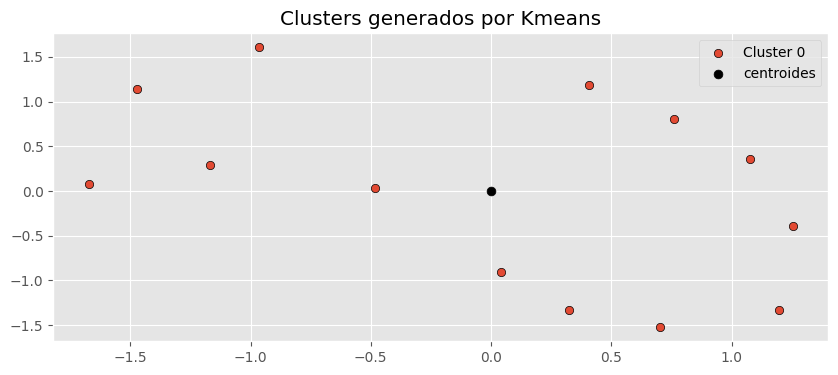

In [27]:
#Para en caso en el que tengamos más de un barco hará un clustering con kmeans para clasificar las diferentes paradas
#De momento dejaremos el n_barcos fijos igual a 1 pero el algoritmo está preparado para que en algún momento se puedan añadir más
n_barcos = 1

style.use('ggplot') or plt.style.use('ggplot')

x_k, y=paradas[0], paradas[1]
X_scaled = scale(paradas)
modelo_kmeans = KMeans(n_clusters=n_barcos, n_init=25, random_state=123)
modelo_kmeans.fit(X=X_scaled)

# Clasificación con el modelo kmeans

y_predict = modelo_kmeans.predict(X=X_scaled)

#Representación
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

for i in np.unique(y_predict):
    ax.scatter(
        x = X_scaled[y_predict == i, 0],
        y = X_scaled[y_predict == i, 1], 
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black', 
        label= f"Cluster {i}"
    )
    
ax.scatter(
    x = modelo_kmeans.cluster_centers_[:, 0],
    y = modelo_kmeans.cluster_centers_[:, 1], 
    c = 'black',
    s = 40,
    marker = 'o',
    label  = 'centroides'
)
ax.set_title('Clusters generados por Kmeans')
ax.legend();

0
Maximum Span: 0.001
Function Evaluations: 2000
[ 0 11  9 10  2  7  4  5  1  6  3  8 12]


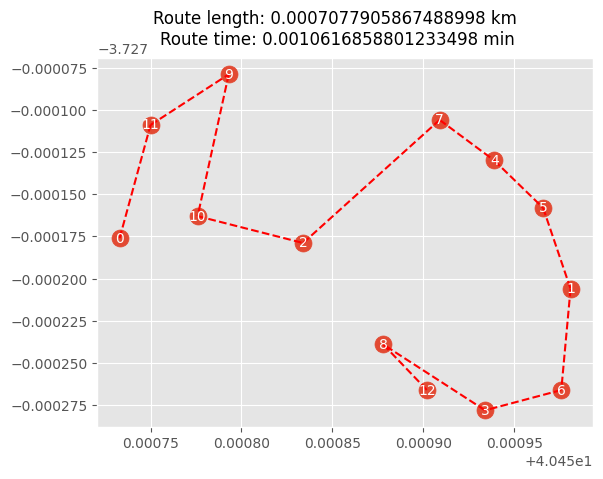

In [28]:
#Creamos un diccionario para almacenar cada ruta
rutas={}
stops=paradas.astype(float)
fitness=[]

for i in range(n_barcos):
    print(i)
    grupos_finales=np.array([stops[:,0].T, stops[:,1].T, y_predict])
    grupos_finales=grupos_finales.T
    rutas[f"ruta_{i}"]=grupos_finales[grupos_finales[:,2]==i][:,:2]
from pymoo.core.sampling import Sampling
for i in range(n_barcos):
    n_stops=len(stops)
    problem = RUTA()

        
    class CustomSampling(Sampling):
        def _do(self, problem, n_samples, **kwargs):
            # Generar n_samples rutas aleatorias
            samples = []
            for _ in range(n_samples):
                # Crear una ruta aleatoria (permutación de las paradas)
                route = np.random.permutation(n_stops)
                #print(f"n_paradas {n_stops}")
                samples.append(route)
                #print(f"samples {samples}")
            return np.array(samples)

    sampling=CustomSampling()  
    algorithm = NSGA2(
        pop_size=20,
        sampling=sampling,
        mutation=InversionMutation(),
        #mutation=BitflipMutation(),
        crossover=OrderCrossover(),
        repair=StartFromZeroRepair(),
        eliminate_duplicates=True,
        save_history=True,
        #verbose=True
    )
    
    # if the algorithm did not improve the last 200 generations then it will terminate (and disable the max generations)
    #termination = DefaultSingleObjectiveTermination(period=200, n_max_gen=np.inf)
    
    res = minimize(
        problem,
        algorithm,
        termination=('n_gen',100),
        seed=1,
        verbose=False,
    )
    print("Maximum Span:", np.round(res.F[0], 3))
    print("Function Evaluations:", res.algorithm.evaluator.n_eval)
    print(res.X)
    %matplotlib inline
    visualize_3(problem, res.X, n_barcos)
    


In [35]:
dtype = [('nombre', 'U10'), ('lat', 'f4'), ('lon', 'f4')]  # U10 para string, f4 para float
waypoint_array = np.array(waypoint_list, dtype=dtype)
unchanged_array = np.zeros(len(unchangedpoints), dtype = dtype)

#Rellenamos este array
for i, (nombre, x_str, y_str) in enumerate(unchangedpoints):
    unchanged_array[i] = (nombre, float(x_str), float(y_str)) 

#Aqui se realiza la ordenación de los BZ, es decir, el elemento resultado[i] va a ser el elemento que marque res.X (obtenido del algoritmo de opt)
resultado = np.zeros(len(res.X),dtype=dtype)
for i in range(len(res.X)):
    idx = res.X[i]
    
    resultado[i] = (f'BZ{i}', waypoint_list[idx][1], waypoint_list[idx][2])

waypoints= resultado
print(waypoints)

[('BZ0', 40.450733, -3.727176 ) ('BZ1', 40.45075 , -3.727109 )
 ('BZ2', 40.450794, -3.727079 ) ('BZ3', 40.450775, -3.727163 )
 ('BZ4', 40.450832, -3.7271788) ('BZ5', 40.45091 , -3.727106 )
 ('BZ6', 40.45094 , -3.72713  ) ('BZ7', 40.450966, -3.727158 )
 ('BZ8', 40.45098 , -3.727206 ) ('BZ9', 40.450977, -3.727266 )
 ('BZ10', 40.450935, -3.727278 ) ('BZ11', 40.45088 , -3.727239 )
 ('BZ12', 40.4509  , -3.727266 )]


In [37]:
print(paradas)

[['40.450733' '-3.727176']
 ['40.450981' '-3.727206']
 ['40.4508339' '-3.7271789']
 ['40.450934' '-3.727278']
 ['40.450939' '-3.72713']
 ['40.4509659' '-3.7271581']
 ['40.4509759' '-3.727266']
 ['40.450909' '-3.727106']
 ['40.450878' '-3.727239']
 ['40.450793' '-3.727079']
 ['40.4507759' '-3.727163']
 ['40.45075' '-3.727109']
 ['40.450902' '-3.727266']]


In [30]:
unchangedpoints.dtype

dtype('<U32')

In [31]:
res.X

array([ 0, 11,  9, 10,  2,  7,  4,  5,  1,  6,  3,  8, 12])

In [32]:
resultado

array([('BZ0', 40.450733, -3.727176 ), ('BZ1', 40.45075 , -3.727109 ),
       ('BZ2', 40.450794, -3.727079 ), ('BZ3', 40.450775, -3.727163 ),
       ('BZ4', 40.450832, -3.7271788), ('BZ5', 40.45091 , -3.727106 ),
       ('BZ6', 40.45094 , -3.72713  ), ('BZ7', 40.450966, -3.727158 ),
       ('BZ8', 40.45098 , -3.727206 ), ('BZ9', 40.450977, -3.727266 ),
       ('BZ10', 40.450935, -3.727278 ), ('BZ11', 40.45088 , -3.727239 ),
       ('BZ12', 40.4509  , -3.727266 )],
      dtype=[('nombre', '<U10'), ('lat', '<f4'), ('lon', '<f4')])

In [33]:
#Si se añade para que vaya más de un barco esto habrá que modificarlo para que cree diferentes archivos
# Reescribir todos los waypoints organizados desde 'resultados'

for name, x, y in resultado:
    new_waypoint = ET.Element('waypoint', name=name, lat=str(x), lon=str(y))
    way_points.append(new_waypoint)
for name, x, y in unchangedpoints:
    new_unchanged = ET.Element('waypoint', name=name, x=str(x), y=str(y))
    way_points.append(new_unchanged)

# Función para formatear el XML
def prettify(element):
    """ Devuelve una versión 'bonita' del XML """
    rough_string = ET.tostring(element, 'utf-8')
    reparsed = minidom.parseString(rough_string)
    return reparsed.toprettyxml(indent="  ")

# Guardar los cambios en el archivo XML
with open('/home/dacya-iagesbloom/Documents/paparazzi/conf/flight_plans/UCM/PRUEBA2_steering_rover_gvfMission_parametric_bare_opt.xml', 'w', encoding='utf-8') as f:
    f.write(prettify(root))

print("Waypoints reescritos y guardados en 'archivo_actualizado.xml'")

Waypoints reescritos y guardados en 'archivo_actualizado.xml'


In [34]:
resultado

array([('BZ0', 40.450733, -3.727176 ), ('BZ1', 40.45075 , -3.727109 ),
       ('BZ2', 40.450794, -3.727079 ), ('BZ3', 40.450775, -3.727163 ),
       ('BZ4', 40.450832, -3.7271788), ('BZ5', 40.45091 , -3.727106 ),
       ('BZ6', 40.45094 , -3.72713  ), ('BZ7', 40.450966, -3.727158 ),
       ('BZ8', 40.45098 , -3.727206 ), ('BZ9', 40.450977, -3.727266 ),
       ('BZ10', 40.450935, -3.727278 ), ('BZ11', 40.45088 , -3.727239 ),
       ('BZ12', 40.4509  , -3.727266 )],
      dtype=[('nombre', '<U10'), ('lat', '<f4'), ('lon', '<f4')])

In [13]:
unchangedpoints

array([['HOME', '0.0', '0.0'],
       ['STDBY', '-1.2', '-14.4'],
       ['ELLIPSE', '-2.7', '-10.6'],
       ['P1', '-4.4', '-12.8'],
       ['P2', '1.6', '-13.1'],
       ['_S1', '3.0', '4.0'],
       ['_S2', '3.0', '-4.0'],
       ['_S3', '-3.0', '-4.0'],
       ['_S4', '-3.0', '4.0'],
       ['_N1', '60.0', '60.0'],
       ['_N2', '60.0', '-60.0'],
       ['_N3', '-60.0', '-60.0'],
       ['_N4', '-60.0', '60.0'],
       ['L0', '0.0', '10.0'],
       ['L1', '0.0', '15.0'],
       ['L2', '0.0', '20.0'],
       ['L3', '-5.0', '20.0'],
       ['L4', '-5.0', '15.0'],
       ['L5', '-5.0', '10.0'],
       ['L6', '-5.0', '5.0']], dtype='<U32')